<a href="https://colab.research.google.com/github/JinFree/models/blob/master/object_detection_api_in_colab_with_gdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq protobuf-compiler python-pil python-lxml python-tk
!pip install tensorflow-gpu Cython jupyter matplotlib | grep Successfully 
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
%cd /content
!git clone https://github.com/tensorflow/models.git
!git clone https://github.com/cocodataset/cocoapi.git
%cd /content/cocoapi/PythonAPI 
!make 
!cp -r pycocotools /content/models/research/
%cd /content/models/research
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
%cd /content/models/research
!python object_detection/builders/model_builder_test.py

/content/models/research/object_detection


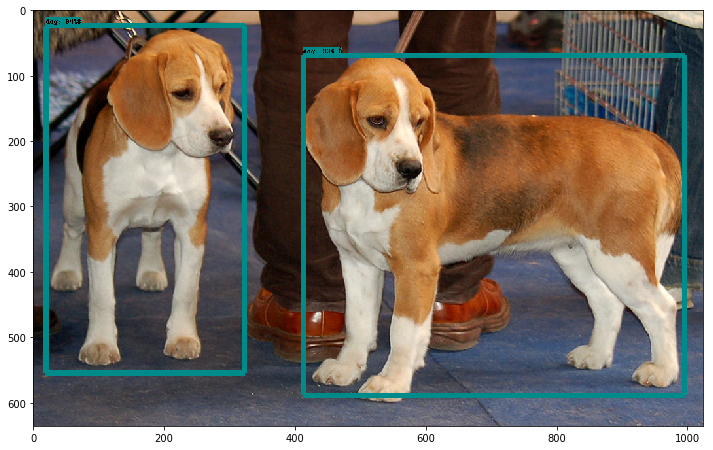

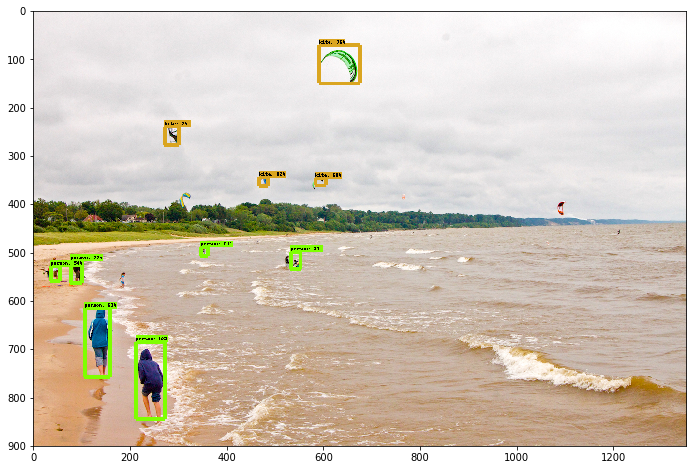

In [5]:
%cd /content/models/research/object_detection
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')
# This is needed to display the images.
%matplotlib inline
from utils import label_map_util

from utils import visualization_utils as vis_util
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)


In [0]:
%cd /content
!mkdir coco
%cd /content/coco
!wget -q http://images.cocodataset.org/zips/train2014.zip
!wget -q http://images.cocodataset.org/zips/val2014.zip
!wget -q http://images.cocodataset.org/zips/test2014.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget -q http://images.cocodataset.org/annotations/image_info_test2014.zip
!unzip -qq train2014.zip 
!ls
!unzip -qq val2014.zip 
!ls
!unzip -qq test2014.zip 
!ls
!unzip -qq annotations_trainval2014.zip 
!ls
!unzip -qq image_info_test2014.zip

In [0]:
!ls /content/coco/annotations

In [14]:
%cd /content/coco
!rm -rf tfrecord
!mkdir tfrecord
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
%cd /content/models/research/object_detection/dataset_tools
!python create_coco_tf_record.py --logtostderr \
      --train_image_dir=/content/coco/train2014/ \
      --val_image_dir=/content/coco/val2014/ \
      --test_image_dir=/content/coco/test2014/ \
      --train_annotations_file=/content/coco/annotations/instances_train2014.json \
      --val_annotations_file=/content/coco/annotations/instances_val2014.json \
      --testdev_annotations_file=/content/coco/annotations/image_info_test2014.json \
      --output_dir=/content/coco/tfrecord | grep Finished

I0820 14:20:53.594248 139973916100480 create_coco_tf_record.py:236] On image 39800 of 40775
I0820 14:20:54.020756 139973916100480 create_coco_tf_record.py:236] On image 39900 of 40775
I0820 14:20:54.438478 139973916100480 create_coco_tf_record.py:236] On image 40000 of 40775
I0820 14:20:54.794594 139973916100480 create_coco_tf_record.py:236] On image 40100 of 40775
I0820 14:20:55.165089 139973916100480 create_coco_tf_record.py:236] On image 40200 of 40775
I0820 14:20:55.538841 139973916100480 create_coco_tf_record.py:236] On image 40300 of 40775
I0820 14:20:56.043456 139973916100480 create_coco_tf_record.py:236] On image 40400 of 40775
I0820 14:20:56.427388 139973916100480 create_coco_tf_record.py:236] On image 40500 of 40775
I0820 14:20:57.139765 139973916100480 create_coco_tf_record.py:236] On image 40600 of 40775
I0820 14:20:57.494215 139973916100480 create_coco_tf_record.py:236] On image 40700 of 40775
I0820 14:20:57.746733 139973916100480 create_coco_tf_record.py:244] Finished wri

In [15]:
!pwd
%cd /content/coco/tfrecord
!ls

/content/models/research/object_detection/dataset_tools
/content/coco/tfrecord
coco_testdev.record-00000-of-00100  coco_train.record-00005-of-00100
coco_testdev.record-00001-of-00100  coco_train.record-00006-of-00100
coco_testdev.record-00002-of-00100  coco_train.record-00007-of-00100
coco_testdev.record-00003-of-00100  coco_train.record-00008-of-00100
coco_testdev.record-00004-of-00100  coco_train.record-00009-of-00100
coco_testdev.record-00005-of-00100  coco_train.record-00010-of-00100
coco_testdev.record-00006-of-00100  coco_train.record-00011-of-00100
coco_testdev.record-00007-of-00100  coco_train.record-00012-of-00100
coco_testdev.record-00008-of-00100  coco_train.record-00013-of-00100
coco_testdev.record-00009-of-00100  coco_train.record-00014-of-00100
coco_testdev.record-00010-of-00100  coco_train.record-00015-of-00100
coco_testdev.record-00011-of-00100  coco_train.record-00016-of-00100
coco_testdev.record-00012-of-00100  coco_train.record-00017-of-00100
coco_testdev.record-0001

In [16]:
%cd /content/coco
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!tar -xzvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!ls /content/coco/ssd_mobilenet_v2_coco_2018_03_29/

/content/coco
--2019-08-20 14:22:25--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.195.128, 2607:f8b0:4001:c11::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187925923 (179M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’

ssd_mobilenet_v2_co 100%[===================>] 179.22M   148MB/s    in 1.2s    

2019-08-20 14:22:26 (148 MB/s) - ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’ saved [187925923/187925923]

ssd_mobilenet_v2_coco_2018_03_29/checkpoint
ssd_mobilenet_v2_coco_2018_03_29/model.ckpt.meta
ssd_mobilenet_v2_coco_2018_03_29/pipeline.config
ssd_mobilenet_v2_coco_2018_03_29/saved_model/saved_model.pb
ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
ssd_mobilenet_v2_coco_2018_03_29/saved_model/
ssd_mobilenet_v2_coco_2018_

In [21]:
%cd /content/coco
!mkdir config_dir
%cd /content/coco/config_dir
!wget https://raw.githubusercontent.com/JinFree/models/master/ssd_inceptionv2_in_colab.config
!ls /content/coco/config_dir

/content/coco
/content/coco/config_dir
--2019-08-20 14:29:08--  https://raw.githubusercontent.com/JinFree/models/master/ssd_inceptionv2_in_colab.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4737 (4.6K) [text/plain]
Saving to: ‘ssd_inceptionv2_in_colab.config’

ssd_inceptionv2_in_ 100%[===================>]   4.63K  --.-KB/s    in 0s      

2019-08-20 14:29:08 (85.3 MB/s) - ‘ssd_inceptionv2_in_colab.config’ saved [4737/4737]



In [0]:
%cd /content/models/research
!python object_detection/model_main.py \
    --pipeline_config_path=/content/coco/config_dir/ssd_inceptionv2_in_colab.config \
    --model_dir=/content/coco/config_dir/ \
    --num_train_steps=50000 \
    --sample_1_of_n_eval_examples=1 \
    --alsologtostderr

I0820 14:35:17.920017 140704431523712 basic_session_run_hooks.py:606] Saving checkpoints for 0 into /content/coco/config_dir/model.ckpt.
2019-08-20 14:35:45.429491: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudnn.so.7
2019-08-20 14:35:48.806120: E tensorflow/stream_executor/cuda/cuda_driver.cc:828] failed to allocate 3.62G (3885383680 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0820 14:35:52.835582 140704431523712 basic_session_run_hooks.py:262] loss = 422.47223, step = 0
I0820 14:37:57.119400 140704431523712 basic_session_run_hooks.py:692] global_step/sec: 0.804584
I0820 14:37:57.128181 140704431523712 basic_session_run_hooks.py:260] loss = 17.237991, step = 100 (124.296 sec)
I0820 14:39:53.805589 140704431523712 basic_session_run_hooks.py:692] global_step/sec: 0.857
I0820 14:39:53.806871 140704431523712 basic_session_run_hooks.py:260] loss = 13.536857, step = 200 (116.679 sec)
I0820 14:41:50.073332 14070443

In [0]:
!ls /content/coco/config_dir/

In [0]:
%cd /content/coco/
!rm -rf ssd_mobilenet_v2_coco_2018_03_29
!mkdir ssd_mobilenet_v2_coco_2018_03_29
%cd /content/models/research
!python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/coco/config_dir/ssd_inceptionv2_in_colab.config \
    --trained_checkpoint_prefix=/content/coco/config_dir \
    --output_directory=/content/coco/ssd_mobilenet_v2_coco_2018_03_29/